In [1]:
import pandas as pd
import numpy as np
import os 
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

In [2]:
sys.path.insert(1, os.path.join(sys.path[0], '../../../openAi/TS_analysis_TOPIC9/'))

In [3]:
from pyts_utils import proximity_tools
from pyts_utils import descriptive_tools
from sklearn.decomposition import PCA

In [4]:
af=pd.read_csv('antifragilidades_datasets/af.csv')

In [5]:
af.iloc[:,2:].corr()

,af_in_pr,af_in_vl,af_ex_pr,af_ex_vl,af_in_pr2,af_in_vl2,af_ex_pr2,af_ex_vl2
af_in_pr,1.000000,0.671100,-0.047607,-0.011621,0.957643,0.785956,-0.036705,-0.024999
af_in_vl,0.671100,1.000000,-0.008078,0.026799,0.774187,0.959194,-0.003471,0.016606
af_ex_pr,-0.047607,-0.008078,1.000000,0.692871,-0.038237,-0.015104,0.957657,0.802626
af_ex_vl,-0.011621,0.026799,0.692871,1.000000,-0.002612,0.016074,0.789997,0.957202
af_in_pr2,0.957643,0.774187,-0.038237,-0.002612,1.000000,0.823725,-0.028250,-0.014912
af_in_vl2,0.785956,0.959194,-0.015104,0.016074,0.823725,1.000000,-0.009681,0.004890
af_ex_pr2,-0.036705,-0.003471,0.957657,0.789997,-0.028250,-0.009681,1.000000,0.831397
af_ex_vl2,-0.024999,0.016606,0.802626,0.957202,-0.014912,0.004890,0.831397,1.000000


Desde las correlaciones vemos que ex e in contienen informacion distinta matematicamente, sin embargo dado el algoritmo de calculo de antifragilidad, podemos considerar que poseen la misma informacion sobre la antifragilidad de los paises en el tiempo? Entonces nos quedamos solo con ex por tener mas datos. Para conservar la mayor cantidad de informacion de antifragilidad data por volumen o precio, podemos projectar al primer PCA considerando las dimensiones af_ex_pr, af_ex_vl

In [6]:
af = af.rename(columns={'Unnamed: 0':'country','Unnamed: 1':'year'})

In [7]:
af=af.iloc[:,[0,1,4,5,8,9]]

In [8]:
af.iloc[:,2:].corr()

,af_ex_pr,af_ex_vl,af_ex_pr2,af_ex_vl2
af_ex_pr,1.000000,0.692871,0.957657,0.802626
af_ex_vl,0.692871,1.000000,0.789997,0.957202
af_ex_pr2,0.957657,0.789997,1.000000,0.831397
af_ex_vl2,0.802626,0.957202,0.831397,1.000000


In [9]:
toproject_af=af.dropna(axis=0)

In [10]:
pca=PCA(n_components=1).fit(toproject_af.iloc[:,2:])

In [11]:
clean_afs = pca.fit_transform(toproject_af.iloc[:,2:])

In [12]:
pca.explained_variance_ratio_.cumsum()

array([0.87781833])

In [13]:
clean_afs = pd.DataFrame(data=clean_afs,columns=['af_ex_pca'])

In [14]:
clean_afs['country'] = toproject_af.reset_index()['country']
clean_afs['year'] = toproject_af.reset_index()['year']

In [19]:
# clean_afs.to_csv('af_ex_pca.csv')

In [71]:
__t = pd.read_excel('cluster.xlsx',index_col=0)

In [72]:
__hist = clean_afs.merge(__t,how='inner',on='country')

In [73]:
__hist

,af_ex_pca,country,year,labels
0,-0.299329,Afghanistan,1987,1
1,-0.276898,Afghanistan,1990,1
2,-0.122803,Afghanistan,1991,1
3,-0.082964,Afghanistan,1992,1
4,0.061521,Afghanistan,1993,1
...,...,...,...,...
4279,-0.012813,Viet Nam,2013,0
4280,0.230696,Viet Nam,2014,0
4281,-0.004328,Viet Nam,2015,0
4282,0.235808,Viet Nam,2016,0


<AxesSubplot:xlabel='af_ex_pca', ylabel='Count'>

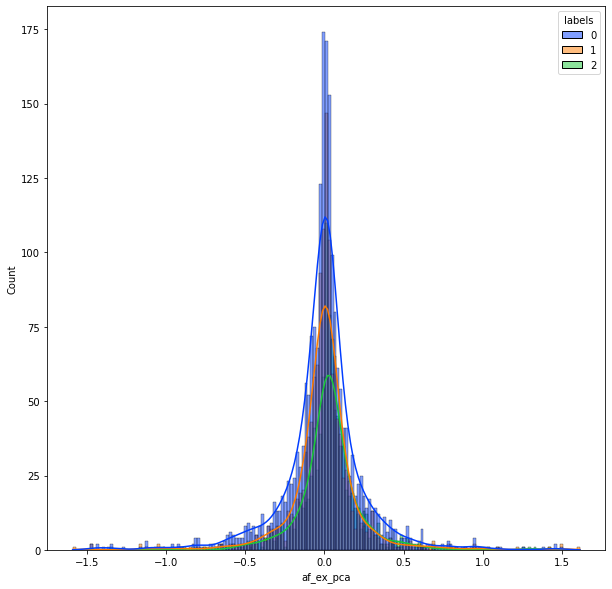

In [74]:
plt.figure(figsize=(10,10))  
sns.histplot(x='af_ex_pca',data=__hist,hue='labels',kde=True,palette='bright')

Tenemos 184 paises importadores y 244 paises exportadores.

Podria ser el caso que los paises que tenemos mas paises exportadores que importadores debido a que los paises que exportan se puede suponer que lo hacen porque les conviene y les sobra los suficiente para ademas poder exportar. Los importadores podemos pensar que importan porque lo necesitan? Podria significar que los paises que no tienen muchos registros como importadores podrian ser los NO-fragiles debido a que no necesitan importar cosas para estar bien?? Los paises que aparecen como importadores pocas veces, aparecen como exportadores muchas veces? Existe esa simetria?? O son asimetricos y pasa que aunque aparescan pocas veces como importadores, tambien aparecen pocos registros de ellos como exportadores??

In [52]:
ex_pr = af.pivot_table(index='year',columns='country',values='af_ex_pr')

In [79]:
from sklearn.cluster import KMeans

In [80]:
km_clust=KMeans(n_clusters=9).fit(ex_pr.dropna(axis=1).T)

KeyError: "Passing list-likes to .loc or [] with any missing labels is no longer supported. The following labels were missing: Index(['Trinidad and Tobago', 'Malta', 'North Macedonia',\n       'Lao People's Democratic Republic', 'Kyrgyzstan',\n       ...\n       'Liberia', 'Bhutan', 'Guinea-Bissau', 'China, Macao SAR', 'Germany'],\n      dtype='object', name='country', length=37). See https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike"

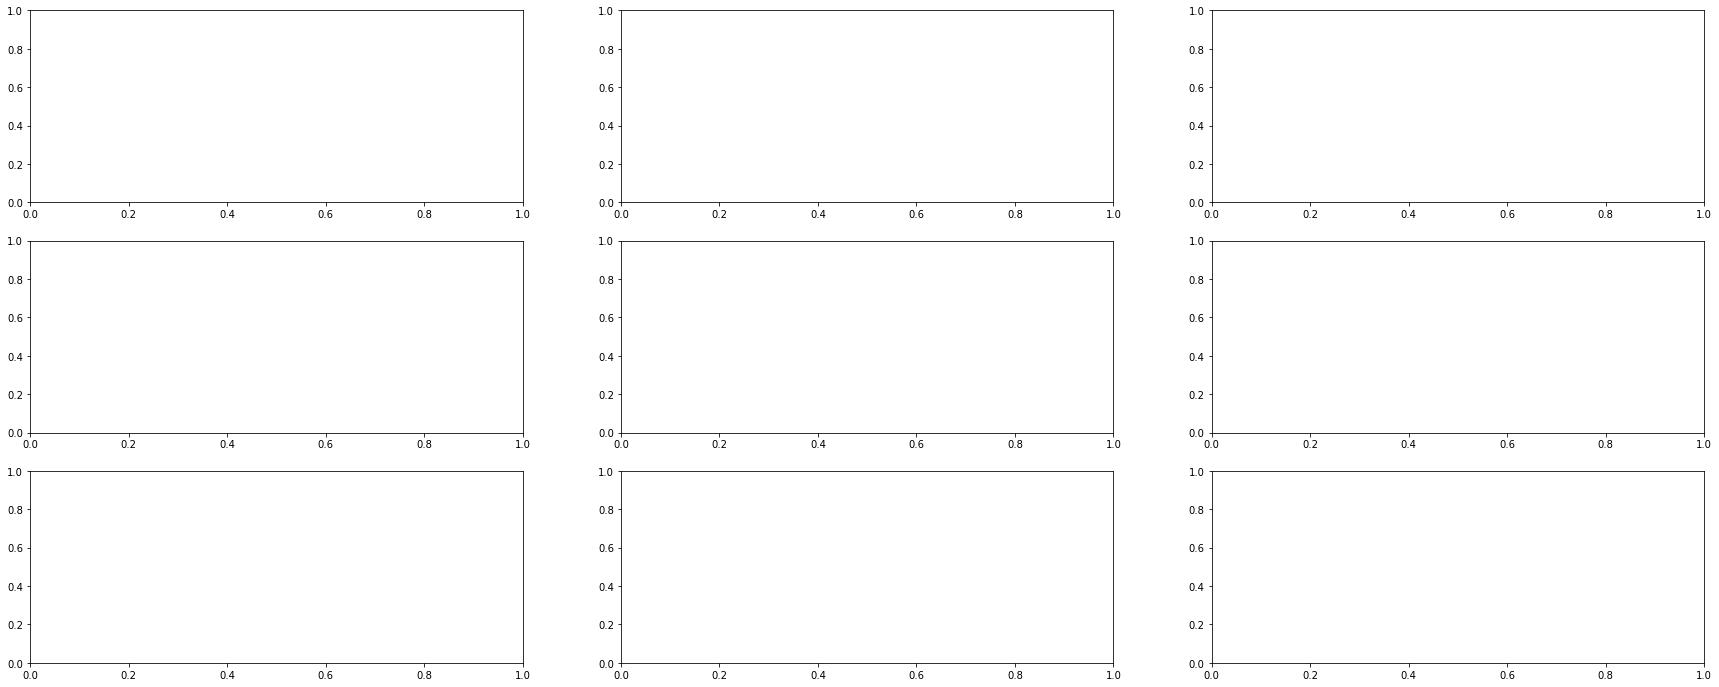

In [55]:
clusters=pd.DataFrame({"country":ex_pr.dropna(axis=1).columns, "cluster":km_clust.labels_})
clusters=clusters.astype('object')

fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(30,12))
axes=axes.flatten()
for i in clusters['cluster'].unique():
    cs=clusters[clusters['cluster']==i]['country']
    ex_pr.dropna(axis=1).loc[:,cs.values].plot(alpha=0.3,ylim=(-1,1),ax=axes[i-1])
    ex_pr.dropna(axis=1).loc[:,cs.values].mean(axis=1).plot(c='r',ax=axes[i-1])    
    axes[i-1].axhline(.5)
    axes[i-1].axhline(-.5)

# clusters.groupby('cluster').apply(lambda cols: ex_pr.dropna(axis=1).loc[:,cols['country'].values].mean(axis=1).plot(figsize=(20,8)))

In [83]:
from sklearn.preprocessing import power_transform

In [186]:
yeo_johnson=power_transform(ex_pr.dropna(axis=1).T,standardize=False)

/home/rogelio/anaconda3/envs/geopandas_env/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2995: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [187]:
yeo_johnson = pd.DataFrame(data=yeo_johnson,index=ex_pr.dropna(axis=1).columns.values,columns=ex_pr.dropna(axis=1).index)

In [188]:
from scipy.cluster.hierarchy import linkage,fcluster
import scipy.spatial.distance as sp 

In [14]:
dMI = lambda x,y: proximity_tools.MI(x,y,bins=3)

In [189]:
# distance_c = np.abs(sp.pdist(ex_pr.dropna(axis=1).T,metric='correlation'))
distance_c=np.abs(sp.pdist(yeo_johnson,metric=proximity_tools.max_xcorr))
# distance_c = 1-np.abs(ex_pr.dropna(axis=1,thresh=15).corr())

In [192]:
# Z=linkage(sp.squareform(distance_c),method='complete',metric='precomputed')
Z=linkage(distance_c,method='complete',metric='precomputed')

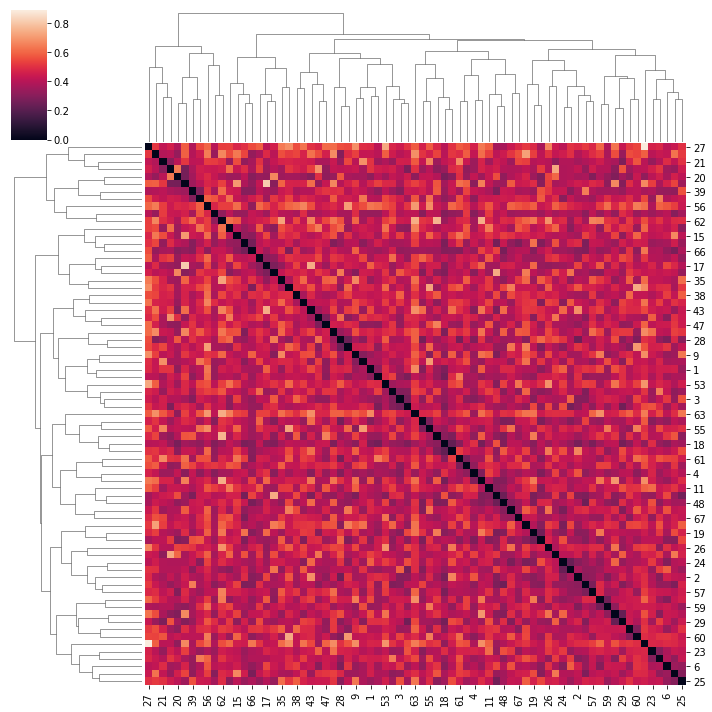

In [194]:
sns.clustermap(sp.squareform(distance_c),row_linkage=Z,col_linkage=Z)

In [180]:
labels = fcluster(Z,54,criterion='maxclust')

In [181]:
clusters=pd.DataFrame({"country":ex_pr.dropna(axis=1,thresh=15).columns, "cluster":labels})
clusters=clusters.astype('object')

In [183]:
fig, axes = plt.subplots(nrows=8, ncols=7,figsize=(30,12))
axes=axes.flatten()
for i in clusters['cluster'].unique():
    cs=clusters[clusters['cluster']==i]['country']
    ex_pr.dropna(axis=1,thresh=15).loc[:,cs.values].plot(alpha=0.3,ylim=(-1,1),ax=axes[i-1])
    ex_pr.dropna(axis=1,thresh=15).loc[:,cs.values].mean(axis=1).plot(c='r',ax=axes[i-1])    
    axes[i-1].axhline(.5)
    axes[i-1].axhline(-.5)
plt.savefig('test.png')
plt.close()

In [155]:
grupos = pd.DataFrame({'countries':ex_pr.dropna(axis=1).columns,'labels':labels})

ValueError: arrays must all be same length

labels
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

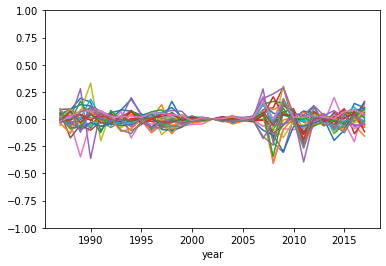

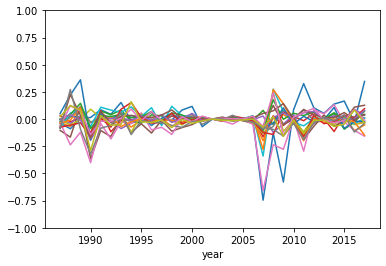

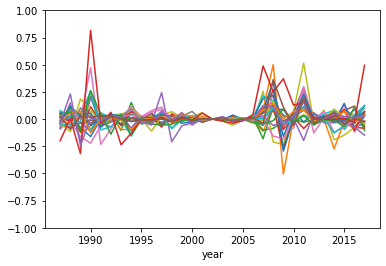

In [23]:
grupos.groupby('labels').apply(lambda cols: ex_pr.loc[:,cols['countries'].values].plot(ylim=(-1,1),legend=False))

labels
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

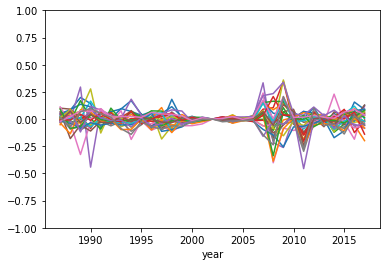

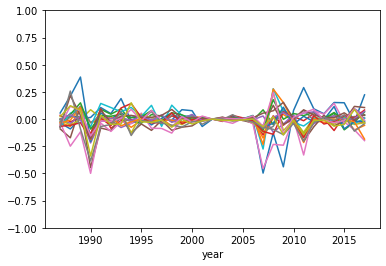

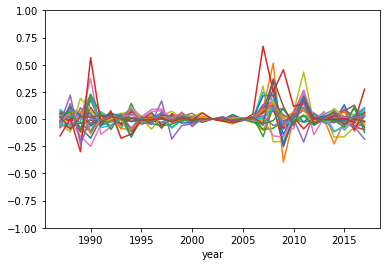

In [22]:
grupos.groupby('labels').apply(lambda cols: yeo_johnson.T.loc[:,cols['countries'].values].plot(ylim=(-1,1),legend=False))

In [64]:
grupos=clusters

In [67]:
grupos=grupos.set_index('country')

In [68]:
pop=pd.read_csv('pairing_data/Population_clean.csv',index_col=0)

In [69]:
pop=pop.pivot_table(values='value',index='date',columns='country.value')

In [70]:
# pop_clean=pop.T.join(grupos,how='inner')
pop_clean=pop.T.join(yeo_johnson,how='inner',rsuffix='yeo')

<AxesSubplot:>

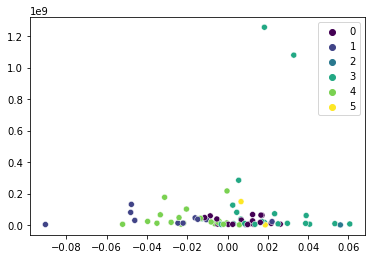

In [73]:
sns.scatterplot(palette='viridis',x=pop_clean.iloc[:,32:].mean(axis=1),y=pop_clean.iloc[:,:32].mean(axis=1),hue=grupos.join(pop_clean,how='inner')['cluster'].values)

/home/rogelio/anaconda3/envs/geopandas_env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


labels
1     AxesSubplot(0.125,0.125;0.775x0.755)
2     AxesSubplot(0.125,0.125;0.775x0.755)
3     AxesSubplot(0.125,0.125;0.775x0.755)
4     AxesSubplot(0.125,0.125;0.775x0.755)
5     AxesSubplot(0.125,0.125;0.775x0.755)
6     AxesSubplot(0.125,0.125;0.775x0.755)
7     AxesSubplot(0.125,0.125;0.775x0.755)
8     AxesSubplot(0.125,0.125;0.775x0.755)
9     AxesSubplot(0.125,0.125;0.775x0.755)
10    AxesSubplot(0.125,0.125;0.775x0.755)
11    AxesSubplot(0.125,0.125;0.775x0.755)
12    AxesSubplot(0.125,0.125;0.775x0.755)
13    AxesSubplot(0.125,0.125;0.775x0.755)
14    AxesSubplot(0.125,0.125;0.775x0.755)
15    AxesSubplot(0.125,0.125;0.775x0.755)
16    AxesSubplot(0.125,0.125;0.775x0.755)
17    AxesSubplot(0.125,0.125;0.775x0.755)
18    AxesSubplot(0.125,0.125;0.775x0.755)
19    AxesSubplot(0.125,0.125;0.775x0.755)
20    AxesSubplot(0.125,0.125;0.775x0.755)
21    AxesSubplot(0.125,0.125;0.775x0.755)
22    AxesSubplot(0.125,0.125;0.775x0.755)
23    AxesSubplot(0.125,0.125;0.775x0.755)
24  

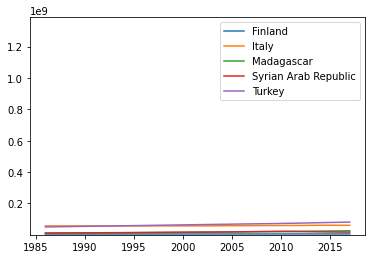

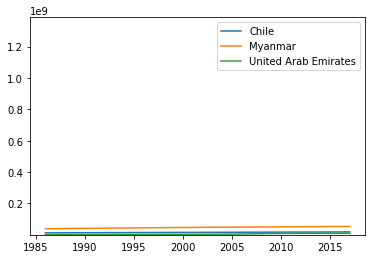

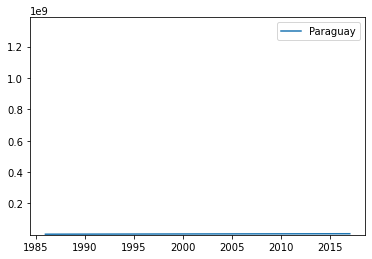

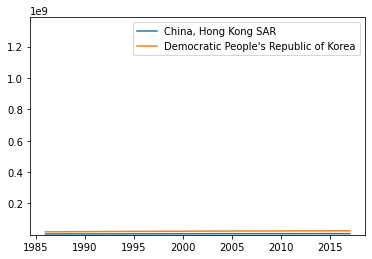

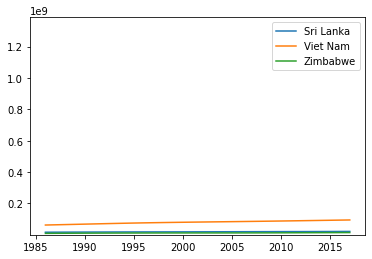

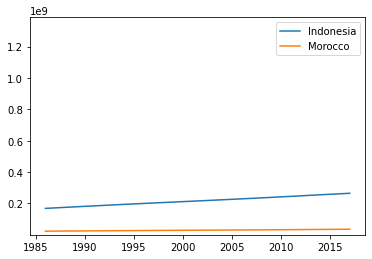

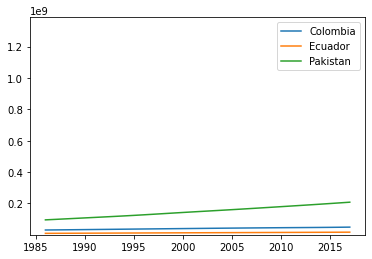

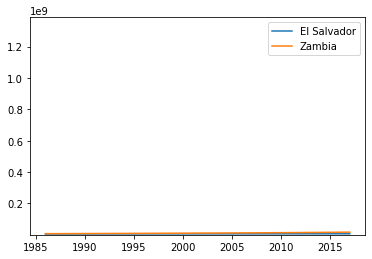

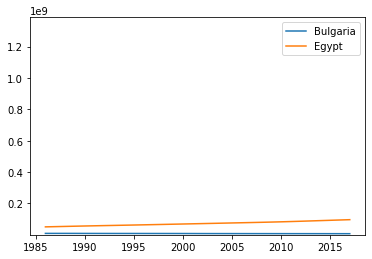

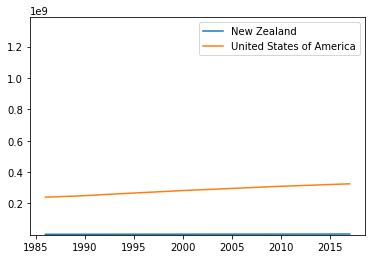

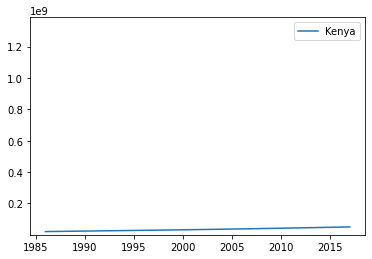

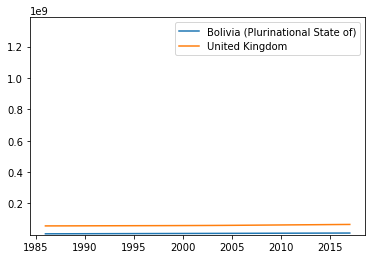

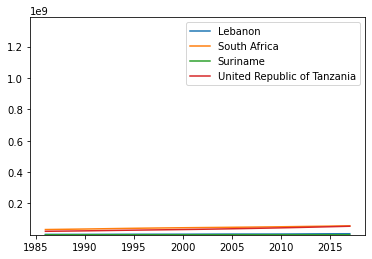

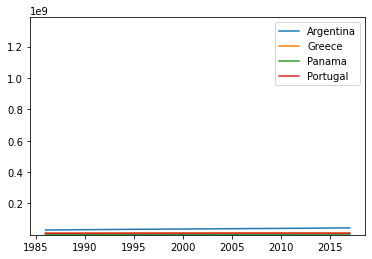

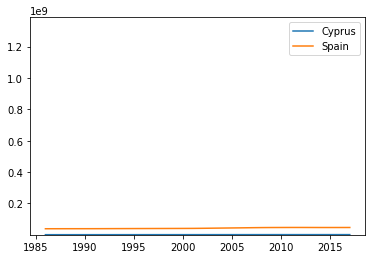

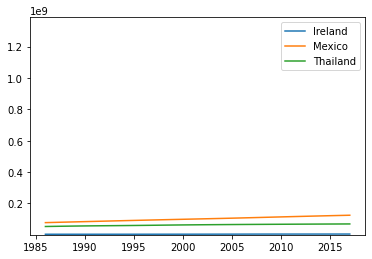

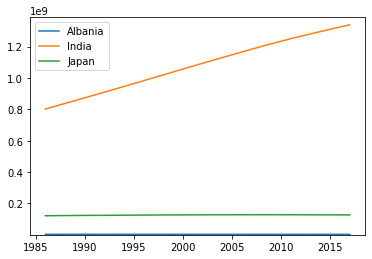

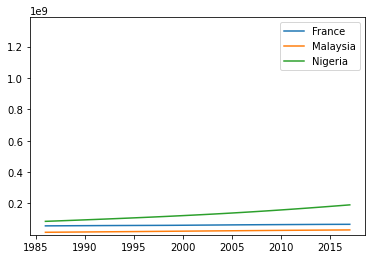

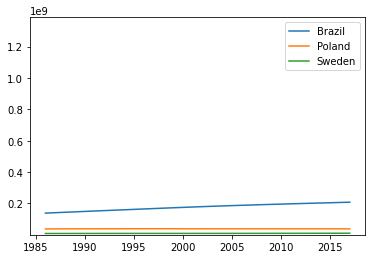

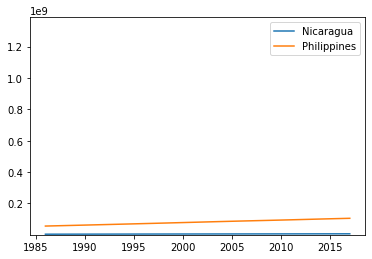

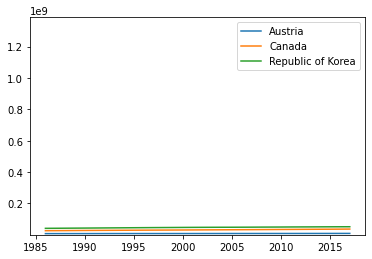

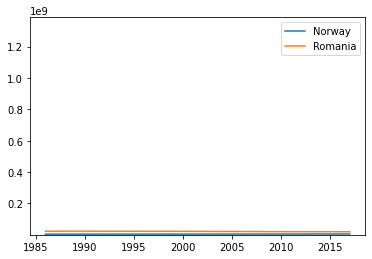

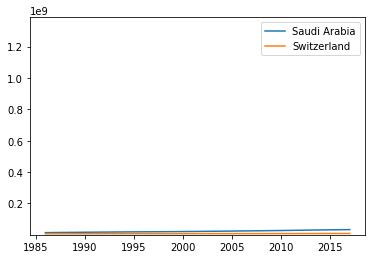

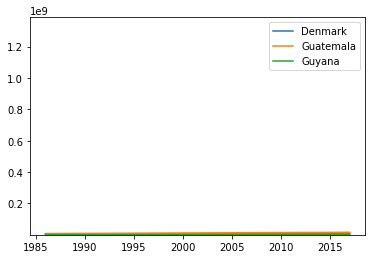

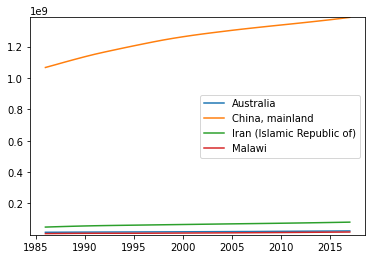

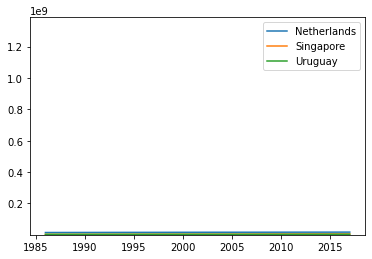

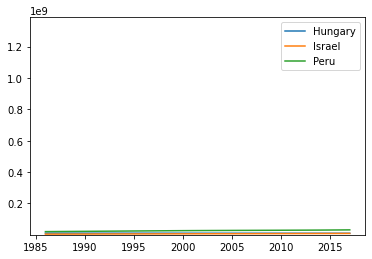

In [166]:
pop_clean.groupby('labels').apply(lambda col: col.T.drop('labels').plot(ylim=(pop_clean.min().min(),pop_clean.max().max())))